# Finding the Weights in Gaussian Quadrature

Copyright (C) 2020 Andreas Kloeckner

<details>
<summary>MIT License</summary>
Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
THE SOFTWARE.
</details>

In [2]:
import numpy as np
import numpy.linalg as la
import scipy.special as sps
import matplotlib.pyplot as pt

Here's a utility routine to do biseciton, to use below:

In [18]:
def bisection(f, a, b, tol=1e-14):
    assert np.sign(f(a)) != np.sign(f(b))
    while b-a > tol:
        m = a + (b-a)/2
        fm = f(m)
        if np.sign(f(a)) != np.sign(fm):
            b = m
        else:
            a = m
            
    return m

Set the number of nodes:

In [3]:
n = 5

### Node selection: Plain Gauss

Gauss nodes are the roots of the $n$th Legendre polynomial $P_n$:

/usr/local/lib/python3.5/dist-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/usr/local/lib/python3.5/dist-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


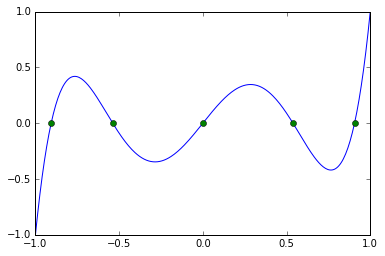

In [5]:
nodes = sps.legendre(n).weights[:, 0]

mesh = np.linspace(-1, 1, 300)

pt.plot(mesh, sps.eval_legendre(n, mesh))
pt.plot(nodes, 0*nodes, "o")

### Node Selection: Gauss-Lobatto

Gauss-Lobatto nodes are (except for the endpoints) the roots of $P_{n-1}'$:

(See [here](https://en.wikipedia.org/wiki/Legendre_polynomials#Additional_properties_of_Legendre_polynomials) or [here](http://dlmf.nist.gov/18.9.17) for a formula for $P_n'$.)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide


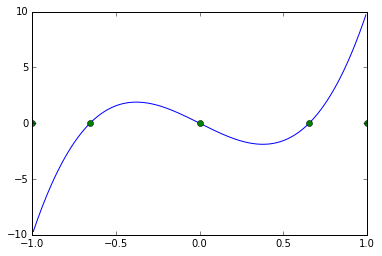

In [27]:
def eval_legendre_deriv(n, x):
    return (
        (x*sps.eval_legendre(n, x) - sps.eval_legendre(n-1, x))
        /
        ((x**2-1)/n))

brackets = sps.legendre(n-1).weights[:, 0]

nodes = np.zeros(n)
nodes[0] = -1
nodes[-1] = 1

from functools import partial

# Use the fact that the roots of P_{n-1} bracket the roots of P_{n-1}':
for i in range(n-2):
    nodes[i+1] = bisection(
        partial(eval_legendre_deriv, n-1),
        brackets[i], brackets[i+1])

mesh = np.linspace(-1, 1, 300)

pt.plot(mesh, eval_legendre_deriv(n-1, mesh))
pt.plot(nodes, 0*nodes, "o")

### Node Selection: Gauss-Radau

For Gauss-Radau (with the left endpoint included), the nodes are the roots of the following function:

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide


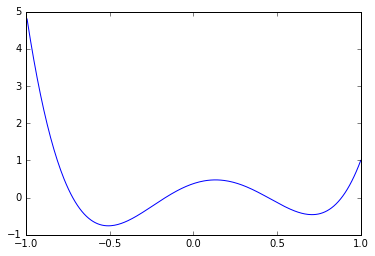

In [31]:
def radau_func(n, x):
    return (
        (sps.eval_legendre(n-1, x) + sps.eval_legendre(n, x))
        /
        (1+x))

nodes = None
# Root finding left as an exercise for the reader. :)

mesh = np.linspace(-1, 1, 300)
pt.plot(mesh, radau_func(n, mesh))

### Finding the weights

Use method of undetermined coefficients to find the interpolatory quadrature rule for `nodes`:

In [24]:
max_degree = len(nodes) - 1
powers = np.arange(max_degree+1)

Vt = nodes ** powers.reshape(-1, 1)

a, b = -1, 1
rhs = 1/(powers+1) * (b**(powers+1) - a**(powers+1))

weights = la.solve(Vt, rhs)

Now compare the approximate integrals of monomials from our rule with the true answers:

In [25]:
for i in range(2*n + 1):
    approx = weights @ nodes**i
    true = 1/(i+1)*(1. - (-1)**(i+1))
    
    print("Error at degree %d: %g" % (i, approx-true))

Error at degree 0: 0
Error at degree 1: -1.66533e-16
Error at degree 2: 1.11022e-16
Error at degree 3: -2.498e-16
Error at degree 4: 2.22045e-16
Error at degree 5: -3.21965e-15
Error at degree 6: -8.88178e-16
Error at degree 7: -4.4964e-15
Error at degree 8: 0.0145125
Error at degree 9: -5.02376e-15
Error at degree 10: 0.0339253
